In [1]:
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\LAKSHMI SRI
[nltk_data]     LASYA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\LAKSHMI SRI
[nltk_data]     LASYA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\LAKSHMI SRI
[nltk_data]     LASYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
import json
dataList = []
sentences = []
labels = []
def loadDataset(filename):
  d=[]
  with open(filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    d.append([sentence,label])
  return d
# Loading both sensitive and non-sensitive dataset
sen=loadDataset("SensitiveDataset.json")
nonsen=loadDataset("NonSensitiveDatasetnew.json")
sen=pd.DataFrame(data=sen,columns=['sentences','labels'])
nonsen=pd.DataFrame(data=nonsen,columns=['sentences','labels'])

In [34]:
combined = pd.concat([sen, nonsen])
df = combined.sample(frac=1).reset_index(drop=True)
df.head()

,sentences,labels
0,"card no:6546 2697 4263 5350, expiry month:apr-...",1
1,"brooklynn, molly1, brooklynn@ntlworld.co...",1
2,Toodie and Budge are identified as the two bes...,0
3,"In a New York City park, hippies have gathered...",0
4,"pan number:rwpk7747skpe, full name:kanchana k...",1


In [35]:
tokenized_data = [word_tokenize(sentence) for sentence in df['sentences']]
stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
punctuations.remove('@')
stop_words.update(punctuations)
stemmer = PorterStemmer()
filtered_data = [[stemmer.stem(word) for word in sentence if word.lower() not in stop_words] for sentence in tokenized_data]
l=[]
for idx, sentence in enumerate(filtered_data):
    l.append(' '.join(sentence))
df['sentences'] = l

In [36]:
df.head() 

,sentences,labels
0,card no:6546 2697 4263 5350 expiri month apr-2...,1
1,brooklynn molly1 brooklynn @ ntlworld.com 6717...,1
2,toodi budg identifi two best children world en...,0
3,new york citi park hippi gather guitar sing pr...,0
4,pan number rwpk7747skpe full name kanchana kum...,1


In [37]:
df_train = df.sample(frac=.8, random_state=11)
df_test = df.drop(df_train.index)
print(df_train.shape, df_test.shape)

(25261, 2) (6315, 2)


In [38]:
y_train = df_train['labels'].values
y_test = df_test['labels'].values
y_test.shape
y_train.shape

(25261,)

In [39]:
X_train = df_train['sentences'].values
X_test = df_test['sentences'].values

In [11]:
source=len(X_train)
max_len= max(len(seq) for seq in X_train)
print(source,max_len)

25261 14225


In [40]:
# Load the embeddings
embeddings_index = {}
with open('glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Prepare the Tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # `texts` is your list of texts
word_index = tokenizer.word_index

# Prepare the Embedding matrix
embedding_dim = 100 # This should match the dimension of the embeddings you are using
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
len(word_index)

81931

In [41]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
print(X_train_seq[:5])
print(df_train.iloc[0,:])
print(X_train_seq[0])


[[35460, 8848, 35460, 4937, 154, 47310], [4264, 1966, 45, 90, 1572, 6992, 47311, 52, 29, 16, 166, 124, 3584, 328, 1281, 102, 64, 46, 966, 624, 2, 262, 2189, 759, 4075, 47312, 536, 1350, 474, 2189, 119, 464, 922, 30018, 11758, 845, 30019, 480, 4097, 197, 775, 8395, 9824, 416, 64, 362, 64, 1572, 941, 674, 17664, 105, 57, 2, 554, 2275, 61, 1855, 2530, 343, 2774, 1572, 102, 464, 74, 554, 374, 742, 515, 277, 945, 260, 197, 1572, 4, 464, 695, 2275, 415, 4, 22, 16744, 139, 330, 345, 429, 8, 88, 116, 464, 7, 47313, 80, 474, 57, 225, 335, 47314, 429, 4778, 197, 1572, 2, 7392, 844, 21613, 416, 9407, 945, 620, 197, 464, 1678, 29, 265, 986, 810, 2323, 2855, 18, 1638, 2571, 117, 1293, 168, 9407, 463, 1572, 53, 176, 233, 23, 35461, 3090, 1572, 2, 550, 464, 169, 197, 286, 1572, 2, 8849, 725, 3751, 214, 152, 335, 149, 17, 8, 4021, 1583, 492, 627, 106, 2, 395, 60, 323, 35462, 542, 255, 100, 1572, 464, 1572, 30, 7, 3028, 1572, 2, 111, 130, 49, 197, 278, 691, 8111, 89, 30, 106, 2, 334, 489, 60, 803, 102,

In [42]:
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')
X_train_pad[:5]
X_train_pad.shape[0]
#get max number in X_train_pad and X_test_pad
max_num=max([max(seq) for seq in X_train_pad])
max_num

81931

In [15]:
X_test_pad.shape

(6315, 100)

In [16]:
X_train_pad.shape

(25261, 100)

In [17]:
from keras.regularizers import l1
from keras.constraints import max_norm
from keras.layers import Dropout

lstm_model = Sequential()
lstm_model.add(Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False))
lstm_model.add(LSTM(100,kernel_regularizer=l1(0.01), kernel_constraint=max_norm(2.)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         8188000   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 8268501 (31.54 MB)
Trainable params: 80501 (314.46 KB)
Non-trainable params: 8188000 (31.23 MB)
_________________________________________________________________


In [18]:
history = lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test),class_weight={0: 1., 1: 50.})

Epoch 1/10


395/395 [==============================] - 37s 89ms/step - loss: 3.9892 - accuracy: 0.8817 - val_loss: 0.6305 - val_accuracy: 0.9205
Epoch 2/10
395/395 [==============================] - 34s 85ms/step - loss: 0.9084 - accuracy: 0.9028 - val_loss: 1.1873 - val_accuracy: 0.8950
Epoch 3/10
395/395 [==============================] - 34s 87ms/step - loss: 0.4288 - accuracy: 0.9759 - val_loss: 0.2020 - val_accuracy: 0.9970
Epoch 4/10
395/395 [==============================] - 34s 85ms/step - loss: 0.2394 - accuracy: 0.9942 - val_loss: 0.2564 - val_accuracy: 0.9956
Epoch 5/10
395/395 [==============================] - 35s 88ms/step - loss: 0.6379 - accuracy: 0.9435 - val_loss: 0.5471 - val_accuracy: 0.9302
Epoch 6/10
395/395 [==============================] - 34s 86ms/step - loss: 4.4339 - accuracy: 0.7157 - val_loss: 2.7678 - val_accuracy: 0.8811
Epoch 7/10
395/395 [==============================] - 35s 88ms/step - loss: 2.1296 - accuracy: 0.9536 - val_loss: 1.6391 - val_accurac

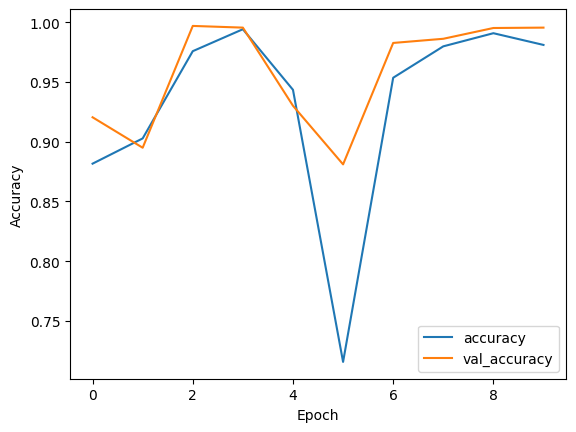

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [21]:
test_loss, test_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=2)


198/198 - 4s - loss: 0.5454 - accuracy: 0.9956 - 4s/epoch - 20ms/step


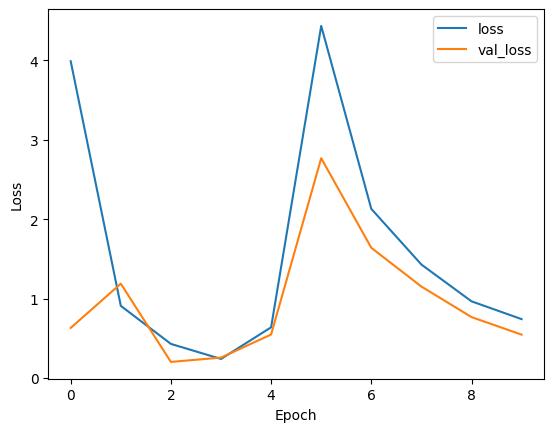

In [22]:
#Draw graph for loss function
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [23]:
test = ['Hi Paul, would you come around tonight']
seq = tokenizer.texts_to_sequences(test)

pad = pad_sequences(seq, maxlen=20, padding='post')
tokenizer.index_word
pad
pred = lstm_model.predict(pad)
# print the class label
if pred > 0.5:
    print('Sensitive')
else:
    print('Non-sensitive')

1/1 [==============================] - 0s 310ms/step
Non-sensitive


In [25]:
test = ['hi im Lasya, mobile number is 1234567890','7789 5643 1234', 'email id: krishna@gmail.com','I would like a cup of coffee in the morning']
for i in test:
    seq = tokenizer.texts_to_sequences([i])
    pad = pad_sequences(seq, maxlen=20, padding='post')
    pred = lstm_model.predict(pad)
    if pred > 0.5:
        print(i, 'Sensitive')
    else:
        print(i, 'Non-sensitive')

1/1 [==============================] - 0s 33ms/step
hi im Lasya, mobile number is 1234567890 Non-sensitive
1/1 [==============================] - 0s 34ms/step
7789 5643 1234 Sensitive
1/1 [==============================] - 0s 33ms/step
email id: krishna@gmail.com Sensitive
1/1 [==============================] - 0s 31ms/step
I would like a cup of coffee in the morning Non-sensitive


In [46]:
from keras.regularizers import l1
from keras.constraints import max_norm
from keras.layers import Dropout

lstm_model = Sequential()
lstm_model.add(Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False))
lstm_model.add(LSTM(400,kernel_regularizer=l1(0.01), kernel_constraint=max_norm(2.)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         8193200   
                                                                 
 lstm_3 (LSTM)               (None, 400)               801600    
                                                                 
 dropout_3 (Dropout)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 401       
                                                                 
Total params: 8995201 (34.31 MB)
Trainable params: 802001 (3.06 MB)
Non-trainable params: 8193200 (31.25 MB)
_________________________________________________________________


In [47]:
history = lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test),class_weight={0: 1., 1: 50.})

Epoch 1/10
395/395 [==============================] - 233s 586ms/step - loss: 6.1550 - accuracy: 0.8824 - val_loss: 1.7199 - val_accuracy: 0.7705
Epoch 2/10
395/395 [==============================] - 392s 991ms/step - loss: 2.0710 - accuracy: 0.7961 - val_loss: 0.7965 - val_accuracy: 0.9172
Epoch 3/10
395/395 [==============================] - 170s 429ms/step - loss: 1.0869 - accuracy: 0.8906 - val_loss: 0.4293 - val_accuracy: 0.9900
Epoch 4/10
395/395 [==============================] - 159s 404ms/step - loss: 1.7164 - accuracy: 0.9076 - val_loss: 12.0608 - val_accuracy: 0.4801
Epoch 5/10
395/395 [==============================] - 187s 474ms/step - loss: 4.9590 - accuracy: 0.5726 - val_loss: 1.8953 - val_accuracy: 0.6228
Epoch 6/10
395/395 [==============================] - 162s 411ms/step - loss: 2.1235 - accuracy: 0.8364 - val_loss: 7.0333 - val_accuracy: 0.7482
Epoch 7/10
395/395 [==============================] - 170s 430ms/step - loss: 2.4543 - accuracy: 0.9673 - val_loss: 0.8609 

In [48]:
test_loss, test_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=2)

198/198 - 7s - loss: 0.3764 - accuracy: 0.9824 - 7s/epoch - 36ms/step


In [54]:
test = ["My social security number is 123-45-6789.",
"My credit card number is 1234 5678 9012 3456.",
"My email address is john.doe@example.com.",
"My phone number is (123) 456-7890.",
"I live at 123 Main St, Anytown, USA.",
"I love to play soccer on the weekends.",
"My favorite color is blue.",
"I enjoy reading books and listening to music.",
"The weather is really nice today.",
"I have a pet dog named Rover.",
'Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results']
sensitive=[]
nonsensitive=[]
for i in test:
    seq = tokenizer.texts_to_sequences([i])
    pad = pad_sequences(seq, maxlen=20, padding='post')
    pred = lstm_model.predict(pad)
    if pred > 0.5:
        sensitive.append(i)
        print(i, 'Sensitive')
    else:
        nonsensitive.append(i)
        print(i, 'Non-sensitive')

1/1 [==============================] - 0s 23ms/step
My social security number is 123-45-6789. Non-sensitive
1/1 [==============================] - 0s 21ms/step
My credit card number is 1234 5678 9012 3456. Non-sensitive
1/1 [==============================] - 0s 22ms/step
My email address is john.doe@example.com. Non-sensitive
1/1 [==============================] - 0s 20ms/step
My phone number is (123) 456-7890. Non-sensitive
1/1 [==============================] - 0s 20ms/step
I live at 123 Main St, Anytown, USA. Non-sensitive
1/1 [==============================] - 0s 25ms/step
I love to play soccer on the weekends. Non-sensitive
1/1 [==============================] - 0s 20ms/step
My favorite color is blue. Non-sensitive
1/1 [==============================] - 0s 22ms/step
I enjoy reading books and listening to music. Non-sensitive
1/1 [==============================] - 0s 22ms/step
The weather is really nice today. Non-sensitive
1/1 [==============================] - 0s 21ms/step
I have

198/198 [==============================] - 10s 51ms/step


<Axes: >

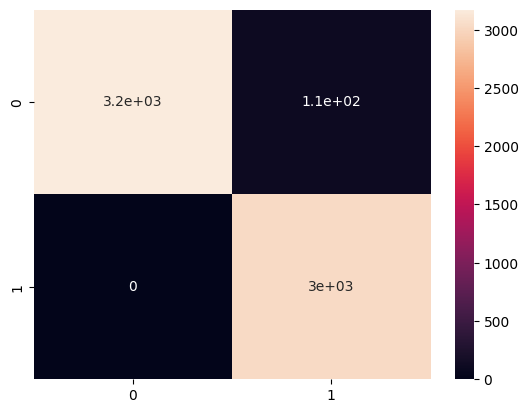

In [51]:
#print confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = lstm_model.predict(X_test_pad)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
sns.heatmap(cm, annot=True)


In [43]:
from keras.regularizers import l1
from keras.constraints import max_norm
from keras.layers import Dropout

lstm_model = Sequential()
lstm_model.add(Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False))
lstm_model.add(LSTM(200,kernel_regularizer=l1(0.01), kernel_constraint=max_norm(2.)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         8193200   
                                                                 
 lstm_2 (LSTM)               (None, 200)               240800    
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 8434201 (32.17 MB)
Trainable params: 241001 (941.41 KB)
Non-trainable params: 8193200 (31.25 MB)
_________________________________________________________________


In [44]:
history = lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test),class_weight={0: 1., 1: 50.}) 

Epoch 1/10
395/395 [==============================] - 67s 167ms/step - loss: 6.2962 - accuracy: 0.8681 - val_loss: 3.4042 - val_accuracy: 0.8499
Epoch 2/10
395/395 [==============================] - 65s 164ms/step - loss: 2.2276 - accuracy: 0.9523 - val_loss: 1.6864 - val_accuracy: 0.9965
Epoch 3/10
395/395 [==============================] - 65s 164ms/step - loss: 3.1427 - accuracy: 0.7670 - val_loss: 1.6343 - val_accuracy: 0.9468
Epoch 4/10
395/395 [==============================] - 67s 171ms/step - loss: 2.4697 - accuracy: 0.7413 - val_loss: 3.8263 - val_accuracy: 0.4801
Epoch 5/10
395/395 [==============================] - 64s 163ms/step - loss: 2.8890 - accuracy: 0.5771 - val_loss: 2.2725 - val_accuracy: 0.4801
Epoch 6/10
395/395 [==============================] - 65s 164ms/step - loss: 2.4110 - accuracy: 0.6155 - val_loss: 1.5420 - val_accuracy: 0.7962
Epoch 7/10
395/395 [==============================] - 64s 163ms/step - loss: 7.1350 - accuracy: 0.5267 - val_loss: 5.9579 - val_ac

In [45]:
test_loss, test_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=2)

198/198 - 5s - loss: 1.8405 - accuracy: 0.9568 - 5s/epoch - 23ms/step
